In [1]:
from IPython.display import display, HTML, Image, clear_output
import numpy as np
import matplotlib.pyplot as plt

<center><span style="color:blue;font-family:helvetica; font-size:3.5rem; font-weight:700;">Sleep Statistics</span></center>


# Useful statistics
- Time in Bed (*TIB*) : total duration of the hypnogram.
- Total Dark Time (*TDT*) : duration of the hypnogram from beginning to last period of sleep.
- Sleep Period Time (*SPT*) : duration from first to last period of sleep.
- Wake After Sleep Onset (*WASO*) : duration of wake periods within SPT
- Sleep Efficiency (*SE*) : TST / TDT * 100 (%).
- Total Sleep Time (*TST*) : SPT - WASO.
- W, N1, N2, N3 and REM : sleep stages duration.
- Latencies : latencies of sleep stages from the beginning of the record.

# Approach
A Python program will be developed to derived the statistics from the hypnograms in the Physionet database. Note that hypnograms in the Physionet database are for the whole period of the polysomnographs. The polysomnographs cover a period of 24 hours. This means that the Time in Bed (TIB) statistic as well as the Total Dark Time (TDT) cannot be measured. 

The following steps will be done:
- create a folder with all the hypnogram.edf files for the Phyionet database
- read these files sequentially in Python
- for each file create a list with the following variables:
 - filename
 - start time hypnogram
 - end time hypnogram
 - start time sleep
 - end time sleep
 - cumulative values for:
   - W
   - N1
   - N2
   - N3
   - REM
   - WASO
   - Movement time
   
After the data is read and recorded in the list, the following statistics can be derived:
- total duration of the hypnogram
- Sleep Period Time (SPT), the duration from first to last period of sleep
- Sleep Efficiency (SE)? This can only be measured for Physionet hypnograms as the ratio TST/SPT

# Program
I have created a program `hypnogram_stats.py` which reads the hypnograms from the Physionet sleep database and creates some statistics. In order to read the hypnograms, I have created a separate folder `Hypnograms` which contains all the `...-Hypnogram.edf` files from the Physionet sleep database.  

In the Physionet hypnograms, there are no annotation about Time in Bed and Total Dark Time. Moreover, a number of the hypnograms are measured over a period of 24 hours. In those cases, there are two large periods of wake time. In addition, some of the hypnograms also contain the annotation "Sleep stage ?". They are mainly right at the end of hypnogram after an annotation "Sleep stage W" but in at least one hypnogram, there is a sequence of "Sleep stage W', Sleep stage ?", "Sleep stage W", "Sleep stage ?".  

In order to handle these situation, I have made the assumption that "Sleep stage ?" can be seen as "Sleep stage W" and will be captured in the statistics as wake outside sleep period.  

Based on this, the program divides the annotations as follows:
- if the hypnogram starts with a "Sleep stage W", this is seen as wake period outside of the sleep period
- the sleep period starts at the start of the first annotation for a sleep stage
- the sleep period ends at the end of the last annotation for a sleep stage
- "Sleep stage W" and "Sleep stage ?" after the end of the sleep period are recorded as wake period outside the sleep period

An outline of the program:
- a nested list called `stats` is created with as first inner list the headings for the various data which will be captured from each hypnogram. The headings are:
 - index 0: filename 
 - index 1: start recording
 - index 2: end recording
 - index 3: total recording time
 - index 4: wake period in hours; this is the period of wake before and after the sleep period
 - index 5: wake period in seconds; this is the period of wake before and after the sleep period
 - index 6: start sleep; this is the start of the first sleep stage annotation
 - index 7: end sleep; this is the end of the last sleep stage annotation
 - index 8: tot sleep time in hours
 - index 9: tot sleep time in seconds
 - index 10: N1 in seconds
 - index 11: N2 in seconds
 - index 12: N3 in seconds; N3 and N4 are combined to N3
 - index 13: Rem in seconds
 - index 14: WASO in seconds; captures "Sleep stage W" during the sleep period
 - index 15: Mov in seconds; captures "Movement time"
- a dictionary called `tr` is created which has as key the sleep stage annotations and as value the index for `stats`
- each hypnogram is read and processed sequentially 
- a template is created for the nested list `stats` with placeholders for the various data to be captured
- the filename is read
- the cursor is set to 176 which is the location of the time the hypnogram started
- the start time is read as 'HH.MM.SS'
- length of the header record is read
- based on the length of the header record, the cursor is set to the start of the annotations 
- the annotations are read as a string
- the string of annotations is split on `'\x00` which is the start of an annotation. This results in a list with the annotations in the current file called `data_hypno_spl`
- almost all hypnograms end with a large number of `x00`s which are eliminated from the list of split annotations
- the length of the list with annotations (without the `X00` entries) is determined
- the nested list `stats` is appended with the template. This creates a new entry in `stats` with the placeholders for the data to be captured
- the filename is entered into  `stats[0]` (filename)
- the start time is entered into `stats[1]` (start time)
- all the entries at the end of the list with annotations (`data_hypno_spl`) which either have `Sleep stage W` or `Sleep stage ?` are processed and then deleted from `data_hypno_spl`. This means that last entry in `data_hypno_stats` is now an annotation of a sleep stage. The processing consists of:
 - the duration is added to `stats[2]` (used to calculated the total duration of the hypnogram)
 - the duration is added to `stat[5]` (wake period outside the sleep period in seconds)
- the remaining entries is `data_hypn_spl` are sequentially processed
 - the first entry which is a start record with no annotation is skipped
 - for the remaining annotation records the following is done:
   - the onset is determined
   - the duration is determined
   - the sleep stage is determined
   - if the sleep stage of the first record is "Sleep stage W", the following is done:
     - the duration is added to `stats[5]` (wake period outside the sleep period in seconds)
     - the duration is added to `stats[6]` (used to calculate the start of sleep period)
   - for all other records which are now all annotations of sleep stages, the following is done:
     - depending on which sleep stage, the appropriate slot of `stats` is updated by adding the duration (`stats[10] - stats[15]`
 - after all annotations of a specific hypnogram are processed, the following steps are done to process the time statistics:
   - the start time of the recording is converted from HH.MM.SS to HH:MM:SS
   - the end time of the recording is computed as HH:MM:SS based on the start time and the total seconds of recording
   - the start time of the sleep period is computed as HH:MM:SS based on the onset of the sleep period in seconds and the start time of the recording
   - the total sleep time in hours is computed based on the time in seconds
   - the total wake time outside the sleep period is computed in hours based on the time in seonds
- after all hypnograms are processed, `stats` is written as a pandas DataFrame called `sleep_stats`



# Program
The Python program "hypnogram_stats.py" is stored in the cell below:

In [161]:
import os
from datetime import datetime, timedelta
import pandas as pd

def update(stats,duration, ind):
    stats[ind]+=duration
    return stats

def time_conv(time_raw):
    return datetime.strftime(datetime.strptime(time_raw,'%H.%M.%S'),'%H:%M:%S')

def time_plus(a,b):
    start_time = datetime.strptime(a,'%H:%M:%S')
    end_time = start_time+ timedelta(0,b)
    diff = end_time - start_time
    time_per = diff.days*24 + diff.seconds/3600
    return datetime.strftime(end_time,'%H:%M:%S'), round(time_per,2)

def time_plus2(a,b):
    start_time = datetime.strptime(a,'%H:%M:%S')
    end_time = start_time+ timedelta(0,b)
    return datetime.strftime(end_time,'%H:%M:%S')

folder_path = 'hypnograms'
stats = [['filename','start rec','end rec','tot rec','wake hrs','wake scs',
          'start sleep', 'end sleep', 'tot sl hrs', 'tot sl scs',
          'N1', 'N2', 'N3', 'Rem', 'WASO', 'Mov']]
tr = {'Sleep stage 1':10,'Sleep stage 2':11, 'Sleep stage 3':12,'Sleep stage 4':12,
      'Sleep stage R':13, 'Sleep stage W':14,'Movement time':15, 'Sleep stage ?':16}

for i, data_file in enumerate(sorted(os.listdir(folder_path))):
    with open(folder_path + '/' + data_file, 'rb') as f:
        templ = ['','',0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        file_name = data_file[:8]
        f.seek(176)
        start = f.read(8).decode('utf8')
        len_hdr = int(f.read(8).decode('utf8'))
        
        f.seek(len_hdr,0)
        data_hypno = f.read().decode('utf8')
        data_hypno_spl = data_hypno.split('\x00')

        ind = data_hypno_spl.index('')
        data_hypno_spl=data_hypno_spl[:ind]
        
        stats.append(templ)
        first = 0
        stats[i+1][0]=file_name
        stats[i+1][1]=start
        
        c_end = 1
        while c_end:
            in_start = data_hypno_spl[-1].find('\x15')
            in_stop = data_hypno_spl[-1].find('\x14')
            duration = int(data_hypno_spl[-1][in_start+1:in_stop] )  
            sleepstage = data_hypno_spl[-1][in_stop+1:-1] 
            if tr[sleepstage] == 14 or tr[sleepstage] == 16:
                stats[i+1][2] += duration
                stats[i+1][5] += duration
                data_hypno_spl = data_hypno_spl[:-1]
            else:
                c_end = 0
        
        ln = len(data_hypno_spl)
        
        for j in range(ln):
            in_start = data_hypno_spl[j].find('\x15')
            if in_start == -1:
                continue
            in_stop = data_hypno_spl[j].find('\x14')
            onset = data_hypno_spl[j][1:in_start]
            duration = int(data_hypno_spl[j][in_start+1:in_stop] )   
            sleepstage = data_hypno_spl[j][in_stop+1:-1]            
            if first == 0:
                
                first=1
                if sleepstage != 'Sleep stage W':
                    stats[i+1]=update(stats[i+1], duration, tr[sleepstage])
                else:
                    stats[i+1][6] += duration
                    stats[i+1][5] += duration
            else:
                stats[i+1]=update(stats[i+1], duration, tr[sleepstage])
                stats[i+1][7] += duration
                stats[i+1][9] += duration
                

            stats[i+1][2] += duration 
            
for i in range(1,len(stats)):
    stats[i][1]=time_conv(stats[i][1])
    stats[i][2], stats[i][3]= time_plus(stats[i][1],stats[i][2])
    stats[i][6]= time_plus2(stats[i][1],stats[i][6])
    stats[i][7], stats[i][8]= time_plus(stats[i][6],stats[i][7])
    stats[i][4] = round(stats[i][5]/3600,2)
    


import csv                
with open('test.csv','w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(stats)
csvFile.close()
                        
df = pd.DataFrame(data = stats[1:], columns=stats[0]) 
df.to_pickle('sleep_stats')
            

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 500)
df = pd.read_pickle('sleep_stats')

In [163]:
df

,filename,start rec,end rec,tot rec,wake hrs,wake scs,start sleep,end sleep,tot sl hrs,tot sl scs,N1,N2,N3,Rem,WASO,Mov
0,SC4001EC,16:13:00,16:13:00,24.00,17.99,64770,00:43:30,06:44:00,6.01,21630,1740,7500,6600,3750,2040,0
1,SC4002EC,14:50:00,14:50:00,24.00,15.60,56160,22:04:30,06:28:30,8.40,30240,1770,11190,8910,6450,1890,30
2,SC4011EH,16:49:00,16:49:00,24.00,15.81,56910,22:48:00,06:59:30,8.19,29490,3270,16860,3150,5100,1110,0
3,SC4012EC,17:00:00,17:00:00,24.00,15.12,54420,22:21:30,07:14:30,8.88,31980,2760,19800,2880,5280,1260,0
4,SC4021EH,16:48:00,16:48:00,24.00,16.46,59250,22:52:30,06:25:00,7.54,27150,2820,16350,2850,4890,240,0
5,SC4022EJ,16:42:00,16:42:00,24.00,16.58,59700,23:00:30,06:25:30,7.42,26700,5520,12060,3570,5370,150,30
6,SC4031EC,16:50:00,16:50:00,24.00,17.07,61440,00:05:30,07:01:30,6.93,24960,1830,14550,1710,6270,600,0
7,SC4032EP,16:49:00,16:49:00,24.00,17.41,62670,00:29:30,07:05:00,6.59,23730,1350,12000,3930,5970,480,0
8,SC4041EC,16:50:00,16:50:00,24.00,14.70,52920,23:36:00,08:54:00,9.30,33480,4980,18600,1590,5880,2400,30
9,SC4042EC,15:04:00,15:04:00,24.00,14.97,53880,00:01:00,09:03:00,9.03,32520,4110,15420,2820,8100,1950,120


In [164]:
round(df.describe(),1)

,tot rec,wake hrs,wake scs,tot sl hrs,tot sl scs,N1,N2,N3,Rem,WASO,Mov
count,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
mean,18.3,10.3,37165.6,7.9,28529.5,2384.3,13422.3,4351.5,5826.9,2509.7,46.7
std,7.7,7.7,27695.8,1.5,5487.4,1345.4,3817.6,2346.6,1779.4,3598.9,84.8
min,6.8,0.0,90.0,4.6,16560.0,390.0,6030.0,60.0,2040.0,120.0,0.0
25%,8.4,0.5,1680.0,7.1,25680.0,1320.0,11190.0,2880.0,4740.0,600.0,0.0
50%,24.0,15.1,54420.0,7.8,27960.0,2160.0,12900.0,3960.0,5970.0,1680.0,0.0
75%,24.0,16.6,59850.0,8.3,29940.0,3060.0,15870.0,5640.0,6960.0,2640.0,60.0
max,24.0,19.4,69840.0,13.8,49710.0,6330.0,24990.0,10500.0,9960.0,20610.0,360.0


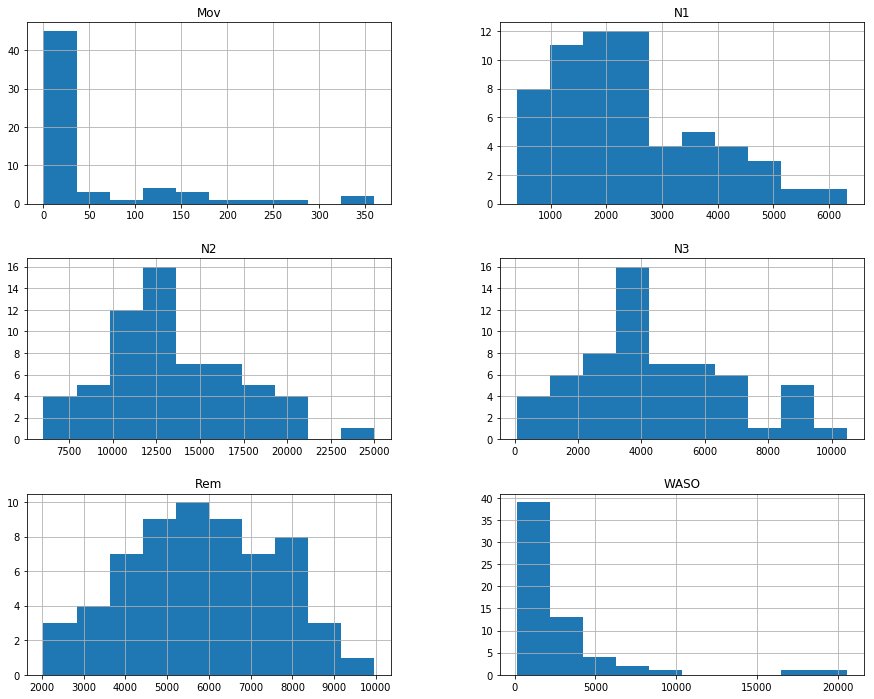

In [165]:
df.hist(column=['N1','N2','N3','Rem','WASO','Mov'], figsize=(15,12));

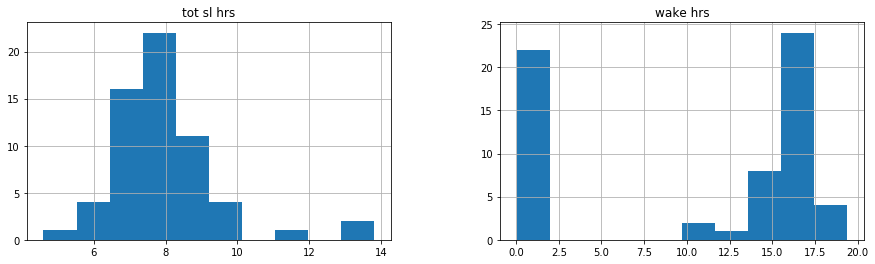

In [166]:
df.hist(column=['wake hrs','tot sl hrs'], figsize=(15,4));

In [202]:
st_sl = pd.to_datetime(df['start sleep'])
end_sl = pd.to_datetime(df['end sleep'])
d = pd.Timedelta('1 days')
st_sl[st_sl.dt.hour > 16] -= d

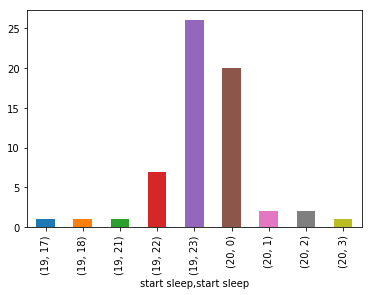

In [205]:
st_sl.groupby([st_sl.dt.day,st_sl.dt.hour]).count().plot(kind='bar')

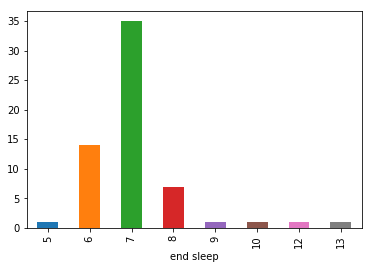

In [208]:
end_sl.groupby(end_sl.dt.hour).count().plot(kind='bar')

# Notes
There are a few cases with very long sleep times:
- SC4152EC:  
the hypnogram annotations start with:
 - Sleep stage W: 10350
 - Sleep stage 1: 60
 - Sleep stage 2: 90
 - Sleep stage R: 180
 - Sleep stage 1: 150
 - Sleep stage 2: 930
 - Sleep stage W: 19740 $\approx 5.5$ hours
 - then $\approx 8.2$ hours sleep
 - overall: 1.5 hours sleep - 5.5 hours wake - 8.2 hours sleep $\rightarrow$ 13.7 hours
- SC4172EC:
 - sleep starts at 18:28:00
 - 1.8 hours of sleep
 - 4.5 hours wake
 - 7.5 hours of sleep
 - $\rightarrow$ 13.8 hours of sleep
- SC4191EP:
 - sleeps starts at 2:04:00
 - sleeps ends at 13:51:30
 - just seems to be a long sleeper
 
 